In [1]:
import os
import math
import pandas as pd
import numpy as np
import pickle

from IPython.display import Audio
import librosa
import tempfile
import subprocess
import soundfile as sf

from enum import Enum
import gc

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.io import wavfile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [2]:
HOP_SIZE = 256
N_FFT = 1024
SAMPLING_RATE = 22050

In [3]:
data_path_orig = 'D:\\lpnu\\магістратура\\диплом\\musdb18'
data_path_wav = 'D:\\lpnu\\магістратура\\диплом\\musdb18_wav'

In [4]:
# class syntax
class Channel(Enum):
    MIXTURE = 0
    DRUMS = 1
    BASS = 2
    OTHER = 3
    VOCALS = 4

## Stems to wav

In [5]:
def to_wav(path, sr):
    with tempfile.TemporaryDirectory() as tmpdir:
        for subdir in ('train', 'test'):
            origin_dir = os.path.join(path, subdir)
            files = [f for f in os.listdir(origin_dir)
                     if os.path.splitext(f)[1] == '.mp4']
            for file in files:
                path = os.path.join(origin_dir, file)
                name = os.path.splitext(file)[0]
                wav_data = []
                # Extract & save the sound of `ch` channel to a temp directory
                # and then concatenate all channels to a single .wav file
                for ch in range(5):
                    temp_fn = f'{name}.{ch}.wav'
                    out_path = os.path.join(tmpdir, temp_fn)
                    subprocess.run(['ffmpeg', '-i', path,
                                    '-map', f'0:{ch}', out_path])
                    sound, _ = librosa.load(out_path, sr=sr, mono=True)
                    wav_data.append(sound)
                wav_data = np.stack(wav_data, axis=1)
                out_path = os.path.join(
                    data_path_wav, subdir, f'{name}.wav')
                sf.write(out_path, wav_data, sr)

In [6]:
def load_df(path, subdir, offset=30, duration=60):
    # Initialize lists to store information
    file_paths = []
    file_names = []
    music_length = []
    sample_rates = []
    music_variations = []

    # Define the directory to search for files
    origin_dir = os.path.join(path, subdir)

    # Iterate through files in the directory and its subdirectories
    for root, _, files in os.walk(origin_dir):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
                file_names.append(file)

                # Read the WAV file using wavfile.read
                song_duration = librosa.get_duration(path=file_path)
                start = 0
                if offset < song_duration/3:
                    start = offset
                    
                audio_data, sample_rate = librosa.load(file_path, sr=None, mono=False, offset=start, duration=duration)
                    
                sample_rates.append(sample_rate)
                
                music_length.append(song_duration)
                #print(type(audio_data[0])
                
                # Append the 5 music variations to the list
                music_variations.append(audio_data.T.astype(np.float32))
                
                del file_path, audio_data, sample_rate
                gc.collect()

    # Create a DataFrame from the collected information
    df = pd.DataFrame({
        'File_Path': file_paths,
        'File_Name': file_names,
        'Music_Length': music_length,
        'Sample_Rate': sample_rates,
    })

    # Add columns for each music variation
    for i in range(5):
        """Output .wav files contain 5 channels
        - `0` - The mixture,
        - `1` - The drums,
        - `2` - The bass,
        - `3` - The rest of the accompaniment,
        - `4` - The vocals.
        """
        df[Channel(i).name] = [variation[:, i] for variation in music_variations]
    
    del file_paths, file_names,sample_rates, music_variations
    gc.collect()
    return df

In [12]:
df = load_df(data_path_wav, 'test', )
df.head()

,File_Path,File_Name,Music_Length,Sample_Rate,MIXTURE,DRUMS,BASS,OTHER,VOCALS
0,D:\lpnu\магістратура\диплом\musdb18_wav\test\A...,Al James - Schoolboy Facination.stem.wav,200.341769,22050,"[0.31326294, 0.30871582, 0.30993652, 0.2319030...","[0.075683594, 0.06951904, 0.08721924, 0.052368...","[0.14157104, 0.13851929, 0.13531494, 0.1319885...","[0.053253174, 0.06463623, 0.07159424, 0.063476...","[0.0473938, 0.038513184, 0.014465332, -0.01925..."
1,D:\lpnu\магістратура\диплом\musdb18_wav\test\A...,AM Contra - Heart Peripheral.stem.wav,209.908390,22050,"[0.099121094, 0.10003662, 0.10290527, 0.106597...","[0.0008239746, 0.0008239746, 0.0008239746, 0.0...","[-3.0517578e-05, -3.0517578e-05, 0.0, 0.0, 0.0...","[0.096710205, 0.097961426, 0.10140991, 0.10525...","[-3.0517578e-05, -3.0517578e-05, -3.0517578e-0..."
2,D:\lpnu\магістратура\диплом\musdb18_wav\test\A...,Angels In Amplifiers - I'm Alright.stem.wav,179.397370,22050,"[0.00036621094, -0.012786865, -0.019470215, -0...","[-0.0011291504, -0.0067443848, 0.0025024414, 0...","[-0.0026550293, -0.0025634766, -0.0025024414, ...","[0.007843018, -0.003540039, -0.020812988, -0.0...","[-0.00033569336, -0.00036621094, -0.0004577636..."
3,D:\lpnu\магістратура\диплом\musdb18_wav\test\A...,Arise - Run Run Run.stem.wav,219.196372,22050,"[-0.08843994, -0.088378906, -0.08843994, -0.08...","[-0.0010375977, -0.0011291504, -0.0011291504, ...","[-0.06484985, -0.066345215, -0.068481445, -0.0...","[-0.010803223, -0.008270264, -0.005218506, -0....","[-0.011810303, -0.012664795, -0.013580322, -0...."
4,D:\lpnu\магістратура\диплом\musdb18_wav\test\B...,Ben Carrigan - We'll Talk About It All Tonight...,254.722902,22050,"[-0.05343628, -0.04660034, -0.082458496, -0.02...","[0.005065918, 0.0052490234, 0.0045776367, 0.00...","[-0.04336548, -0.04699707, -0.050567627, -0.05...","[-0.011566162, -0.010681152, -0.009857178, -0....","[-0.005493164, 0.006072998, -0.02420044, 0.032..."


In [13]:
df.to_pickle('dataset_test.pkl')

In [6]:
df = pd.read_pickle('dataset_test.pkl')

In [9]:
df.head()['MIXTURE'][2].shape

(1323000,)

## WAV to STFT

In [11]:
df = pd.read_pickle('dataset_test.pkl')
df.head()

,File_Path,File_Name,Music_Length,Sample_Rate,MIXTURE,DRUMS,BASS,OTHER,VOCALS
0,D:\lpnu\магістратура\диплом\musdb18_wav\test\A...,Al James - Schoolboy Facination.stem.wav,200.341769,22050,"[0.31326294, 0.30871582, 0.30993652, 0.2319030...","[0.075683594, 0.06951904, 0.08721924, 0.052368...","[0.14157104, 0.13851929, 0.13531494, 0.1319885...","[0.053253174, 0.06463623, 0.07159424, 0.063476...","[0.0473938, 0.038513184, 0.014465332, -0.01925..."
1,D:\lpnu\магістратура\диплом\musdb18_wav\test\A...,AM Contra - Heart Peripheral.stem.wav,209.908390,22050,"[0.099121094, 0.10003662, 0.10290527, 0.106597...","[0.0008239746, 0.0008239746, 0.0008239746, 0.0...","[-3.0517578e-05, -3.0517578e-05, 0.0, 0.0, 0.0...","[0.096710205, 0.097961426, 0.10140991, 0.10525...","[-3.0517578e-05, -3.0517578e-05, -3.0517578e-0..."
2,D:\lpnu\магістратура\диплом\musdb18_wav\test\A...,Angels In Amplifiers - I'm Alright.stem.wav,179.397370,22050,"[0.00036621094, -0.012786865, -0.019470215, -0...","[-0.0011291504, -0.0067443848, 0.0025024414, 0...","[-0.0026550293, -0.0025634766, -0.0025024414, ...","[0.007843018, -0.003540039, -0.020812988, -0.0...","[-0.00033569336, -0.00036621094, -0.0004577636..."
3,D:\lpnu\магістратура\диплом\musdb18_wav\test\A...,Arise - Run Run Run.stem.wav,219.196372,22050,"[-0.08843994, -0.088378906, -0.08843994, -0.08...","[-0.0010375977, -0.0011291504, -0.0011291504, ...","[-0.06484985, -0.066345215, -0.068481445, -0.0...","[-0.010803223, -0.008270264, -0.005218506, -0....","[-0.011810303, -0.012664795, -0.013580322, -0...."
4,D:\lpnu\магістратура\диплом\musdb18_wav\test\B...,Ben Carrigan - We'll Talk About It All Tonight...,254.722902,22050,"[-0.05343628, -0.04660034, -0.082458496, -0.02...","[0.005065918, 0.0052490234, 0.0045776367, 0.00...","[-0.04336548, -0.04699707, -0.050567627, -0.05...","[-0.011566162, -0.010681152, -0.009857178, -0....","[-0.005493164, 0.006072998, -0.02420044, 0.032..."


In [13]:
df['File_Name'][26]

'Nerve 9 - Pray For The Rain.stem.wav'

In [14]:
df['MIXTURE'][26]

array([-0.01394653, -0.01290894, -0.00680542, ..., -0.00247192,
       -0.00683594, -0.00915527], dtype=float32)

In [68]:
display(Audio(data=df['MIXTURE'][0], rate=SAMPLING_RATE)) 

In [7]:
def get_stft(audio_data, sr=22050, n_fft=1024, hop_length=256):
    spec = librosa.stft(audio_data, hop_length=hop_length, n_fft=n_fft )
    db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
    gc.collect()
    return spec.astype(np.float32), db.astype(np.float32)

In [8]:
def plot_stft(audio_data, sr=22050, n_fft=1024, hop_length=256, cmap='viridis'):
    plt.figure(figsize=(12, 8))
    
    spec, db = get_stft(audio_data, sr, n_fft, hop_length)
    #print(len(audio_data))
    #print(db.T.shape)
    librosa.display.specshow(db, sr=sr, hop_length=hop_length, n_fft=n_fft, y_axis='log', x_axis='time')
    #display(Audio(data=librosa.istft(spec.astype(np.complex64), hop_length=hop_length, n_fft=win_length), rate=sr))
    
    #spec = np.abs(librosa.stft(audio_data, hop_length=hop_length, win_length=win_length))
    #librosa.display.specshow(spec, sr=sr, hop_length=hop_length, win_length=win_length, y_axis='log', x_axis='time')
    plt.show()

In [9]:
def create_stft_df(df, sr=22050, n_fft=1024, hop_length=256, threshold=1):
    df_new = pd.DataFrame(index=range(len(df)))
    for index in range(5):
        df_new[Channel(index).name+'_STFT_SPEC'] = None
        if index != 0:
            df_new[Channel(index).name+'_STFT_MASK'] = None
        print(Channel(index).name)
        for j, song in df[Channel(index).name].items():
            spec, _ = get_stft(song, sr, n_fft, hop_length)
            df_new.at[j, Channel(index).name+'_STFT_SPEC'] = spec
            if index != 0:
                mixture_magnitude = df_new['MIXTURE_STFT_SPEC'][j]
                mask = (np.abs(spec) > threshold * np.abs(mixture_magnitude))
                df_new.at[j, Channel(index).name+'_STFT_MASK'] = mask
            gc.collect()
    
    return df_new

In [72]:
df_stft = create_stft_df(df, sr=22050, n_fft=1024, hop_length=256, threshold=0.6)
df_stft.head()

MIXTURE


C:\Users\Orest\AppData\Local\Temp\ipykernel_41788\2086076459.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return spec.astype(np.float32), db.astype(np.float32)


DRUMS


C:\Users\Orest\AppData\Local\Temp\ipykernel_41788\2086076459.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return spec.astype(np.float32), db.astype(np.float32)


BASS


C:\Users\Orest\AppData\Local\Temp\ipykernel_41788\2086076459.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return spec.astype(np.float32), db.astype(np.float32)


OTHER


C:\Users\Orest\AppData\Local\Temp\ipykernel_41788\2086076459.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return spec.astype(np.float32), db.astype(np.float32)


VOCALS


C:\Users\Orest\AppData\Local\Temp\ipykernel_41788\2086076459.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  return spec.astype(np.float32), db.astype(np.float32)


,MIXTURE_STFT_SPEC,DRUMS_STFT_SPEC,DRUMS_STFT_MASK,BASS_STFT_SPEC,BASS_STFT_MASK,OTHER_STFT_SPEC,OTHER_STFT_MASK,VOCALS_STFT_SPEC,VOCALS_STFT_MASK
0,"[[-3.8130162, -2.4191747, -0.10649991, 0.00744...","[[-0.075651005, -0.14758386, 0.053604502, 0.04...","[[False, False, False, True, False, False, Fal...","[[-4.359859, -2.5635529, -0.17021213, -0.15131...","[[True, True, True, True, False, False, False,...","[[0.16367944, 0.09900416, -0.013715524, -0.009...","[[False, False, False, True, False, False, Fal...","[[0.4967175, 0.15183647, -0.060124252, 0.07894...","[[False, False, False, True, False, False, Fal..."
1,"[[1.0016773, 0.7509067, -0.1748649, -0.5135185...","[[-0.144688, 0.023419484, -0.061057054, -0.400...","[[False, False, False, False, True, True, Fals...","[[0.8673369, 0.53689826, -0.13964044, -0.07471...","[[False, False, False, False, False, True, Tru...","[[0.38806167, 0.18944924, -0.018066838, -0.015...","[[False, False, False, False, False, False, Fa...","[[-0.1506785, -0.08618624, -0.022260806, -0.02...","[[False, False, False, False, False, False, Fa..."
2,"[[-1.7170467, -1.6547438, -1.4745969, 0.110832...","[[-0.3537143, 0.68457335, -0.1580286, 0.531701...","[[False, False, False, True, False, False, Fal...","[[-0.986766, -1.5876474, -1.1275975, -1.080458...","[[False, True, False, True, True, True, True, ...","[[-0.21917506, -0.20100228, -0.02146232, 0.079...","[[False, False, False, False, False, True, Fal...","[[-0.24636528, -0.57506585, -0.3028395, 0.2437...","[[False, False, False, True, False, True, True..."
3,"[[-3.1938126, 2.2497292, 1.9454032, -2.9458585...","[[-0.03783432, -0.07570756, -0.00057255116, -0...","[[False, False, False, False, False, False, Fa...","[[-2.875235, 2.6847456, 2.1592076, -2.9588811,...","[[True, True, True, True, True, True, False, T...","[[0.046021044, -0.022939652, -0.043792024, -0....","[[False, False, False, False, False, False, Fa...","[[-0.25709233, -0.29565373, -0.19869767, -0.16...","[[False, False, False, False, False, False, Fa..."
4,"[[0.3706986, 0.025248224, -0.9884916, -6.54603...","[[9.204369, 6.207166, 0.018497262, -1.5851518,...","[[True, True, False, False, False, False, Fals...","[[-7.4418406, -5.4629393, -1.0461572, -4.93302...","[[True, True, True, False, True, False, False,...","[[-1.3599024, -0.6846927, -0.0034719068, -0.01...","[[True, True, False, False, False, False, Fals...","[[0.008456455, 0.011445485, 0.0125697, -0.0017...","[[False, False, False, False, False, False, Fa..."


In [46]:
df_stft.to_pickle('stft_dataset_test.pkl')

## Preprocess STFT dataframe for trining

In [10]:
def sliding_window_middle(lst, n=25):
    result = []
    lst_len = len(lst)
    for i in range(lst_len):
        window = []
        for j in range(n):
            idx = i - n // 2 + j
            if idx < 0:
                window.append(lst[0])
            elif idx >= lst_len:
                window.append(lst[-1])
            else:
                window.append(lst[idx])
        result.append(window)

    return np.array(result)

In [11]:
def process_stft_df(df, n=25):
    new_df = df
    n_mels=513
    sr=22050
    n_fft=1024
    mel_filterbank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    for column in df.columns:
        if column == 'MIXTURE_STFT_SPEC':
            print('special ' + column)
            #df_mel_col = df[column].apply( lambda row: np.transpose(sliding_window_middle(mel_filterbank.dot(row).T, n=25), (0, 2, 1)) )
            #new_df.insert(loc = 0, column = 'MIXTURE_STFT_MEL_FRAME', value = df_mel_col)
            
            df_mel_col = df[column].apply( lambda row: np.transpose(sliding_window_middle(row.T, n=25), (0, 2, 1)) )
            new_df.insert(loc = 0, column = 'MIXTURE_STFT_SPEC_FRAME', value = df_mel_col)
            
        print('general ' + column)
        new_df[column] = df[column].apply( lambda row: row.T )
        
    return new_df
        

In [5]:
df = pd.read_pickle('stft_dataset_test.pkl')
df.head()

,MIXTURE_STFT_SPEC,DRUMS_STFT_SPEC,DRUMS_STFT_MASK,BASS_STFT_SPEC,BASS_STFT_MASK,OTHER_STFT_SPEC,OTHER_STFT_MASK,VOCALS_STFT_SPEC,VOCALS_STFT_MASK
0,"[[-0.67308205, -1.5594838, 1.3152795, 1.195784...","[[0.7138199, 0.23175913, 1.1689886, 1.686425, ...","[[True, False, True, True, True, True, True, T...","[[-1.8983451, -1.792298, 0.22298025, -0.289066...","[[True, True, False, False, False, False, True...","[[0.7343097, 0.15509678, -0.21437863, -0.22426...","[[True, False, False, False, True, False, True...","[[-0.28102127, -0.2652761, -0.11758751, -0.137...","[[False, False, False, False, False, False, Tr..."
1,"[[0.6495609, 0.06387274, 1.2144886, 0.6903477,...","[[0.028773915, -0.13622695, -0.2598854, -0.104...","[[False, True, False, False, False, False, Fal...","[[-0.004513509, -0.008075151, -0.008721575, -0...","[[False, False, False, False, False, False, Fa...","[[0.6085694, 0.10390233, 1.2729067, 0.6357277,...","[[True, True, True, True, True, True, True, Tr...","[[-0.006402482, -0.011150189, -0.011752269, -0...","[[False, False, False, False, False, False, Fa..."
2,"[[-0.46746948, -0.8531813, -0.6666519, 0.16942...","[[-0.52484787, -0.89744765, -0.6720622, 0.0817...","[[True, True, True, False, True, False, True, ...","[[0.16072913, 0.15395305, 0.06752872, -0.00916...","[[False, False, False, False, False, False, Tr...","[[0.03660608, 0.16611807, 0.18835661, 0.012671...","[[False, False, False, False, False, False, Fa...","[[-0.1408517, -0.267067, -0.2572559, 0.0407051...","[[False, False, False, False, False, True, Tru..."
3,"[[-3.1613085, -2.6484091, -2.3248127, -0.37531...","[[-0.7954399, -0.61412317, 0.28059012, 0.06630...","[[False, False, False, False, False, False, Fa...","[[-2.0923877, -1.7609055, -0.63820285, 1.57586...","[[True, True, False, True, True, False, True, ...","[[0.21077004, 0.15754187, -1.9229194, -2.17466...","[[False, False, True, True, False, False, True...","[[-0.4607045, -0.35073325, -0.015874002, 0.080...","[[False, False, False, False, False, False, Fa..."
4,"[[-4.7652507, -2.3674643, -0.37287423, -0.4829...","[[0.23645636, 0.12270055, -0.41012305, -0.7750...","[[False, False, True, True, True, True, True, ...","[[-4.781835, -2.1006565, 0.32168055, 0.2473286...","[[True, True, True, False, False, False, False...","[[-0.19470431, -0.23877375, -0.14251633, -0.01...","[[False, False, False, False, True, False, Fal...","[[-0.06595371, -0.17429148, -0.13164699, -0.00...","[[False, False, False, False, False, False, Fa..."


In [6]:
df['MIXTURE_STFT_SPEC'][26]

array([[ 6.1699396e-01,  9.2490417e-01,  3.2272151e-01, ...,
         2.4715078e-01, -1.9142720e-01,  1.0933729e+00],
       [ 6.0245132e-01, -1.8169938e+00,  5.7895255e-01, ...,
        -1.8372731e+00,  1.3923208e+00, -3.8379356e-01],
       [-3.1983166e+00,  4.1793318e+00, -2.2285721e+00, ...,
         7.3178425e+00, -1.4516907e+00, -3.7960424e+00],
       ...,
       [-5.0260159e-03,  2.2571755e-03,  3.9118044e-05, ...,
         4.1942390e-06,  1.0240491e-04, -3.5443588e-03],
       [ 5.1951543e-03,  1.5556010e-04, -1.2104578e-04, ...,
         6.9295304e-05,  5.5442128e-05, -2.5166378e-06],
       [-5.3021866e-03, -2.7022588e-03,  1.0329081e-04, ...,
        -6.3741034e-05, -1.6619316e-04,  3.1830142e-03]], dtype=float32)

In [8]:
df['MIXTURE_STFT_SPEC'][26]

KeyError: 50

In [7]:
df['MIXTURE_STFT_SPEC'][0].shape

(513, 5168)

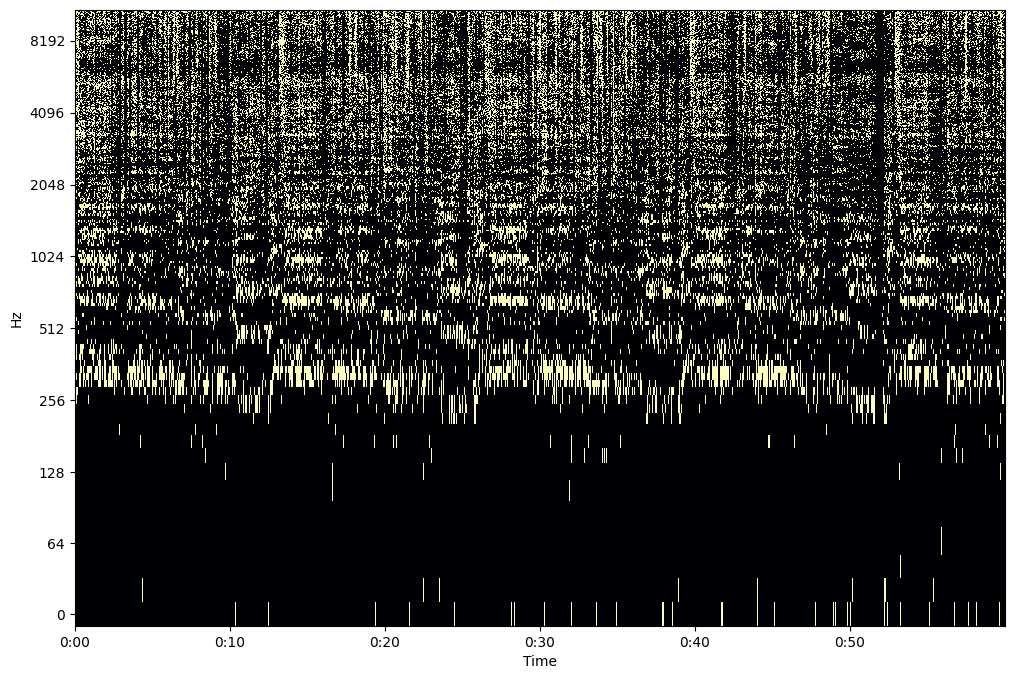

In [78]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(df_stft['VOCALS_STFT_MASK'][4], sr=22050, hop_length=256, win_length=1024, y_axis='log', x_axis='time', cmap='magma')
plt.show()

In [24]:
processed_df = process_stft_df(df)
processed_df.head()

C:\Users\Orest\AppData\Local\Temp\ipykernel_56128\662944309.py:6: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_filterbank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)


special MIXTURE_STFT_SPEC
general MIXTURE_STFT_SPEC
general DRUMS_STFT_SPEC
general DRUMS_STFT_MASK
general BASS_STFT_SPEC
general BASS_STFT_MASK
general OTHER_STFT_SPEC
general OTHER_STFT_MASK
general VOCALS_STFT_SPEC
general VOCALS_STFT_MASK


,MIXTURE_STFT_SPEC_FRAME,MIXTURE_STFT_SPEC,DRUMS_STFT_SPEC,DRUMS_STFT_MASK,BASS_STFT_SPEC,BASS_STFT_MASK,OTHER_STFT_SPEC,OTHER_STFT_MASK,VOCALS_STFT_SPEC,VOCALS_STFT_MASK
0,"[[[-0.67308205, -0.67308205, -0.67308205, -0.6...","[[-0.67308205, 0.7091919, 3.7395122, -9.180677...","[[0.7138199, -1.3688705, 2.3501148, -1.7486998...","[[True, True, True, False, False, False, False...","[[-1.8983451, 2.739884, 0.39843297, -6.092152,...","[[True, True, False, True, True, False, False,...","[[0.7343097, -0.81318873, 1.0691648, -1.349947...","[[True, True, False, False, False, False, Fals...","[[-0.28102127, 0.23598321, -0.21328357, 0.1794...","[[False, False, False, False, False, False, Fa..."
1,"[[[0.6495609, 0.6495609, 0.6495609, 0.6495609,...","[[0.6495609, -0.022872228, 3.804934, -8.898038...","[[0.028773915, -0.07002705, 0.07054093, -0.020...","[[False, True, False, False, False, False, Fal...","[[-0.004513509, 0.0022710606, -4.139277e-06, 5...","[[False, False, False, False, False, False, Fa...","[[0.6085694, 0.03407577, 3.7574008, -8.862426,...","[[True, True, True, True, True, True, True, Tr...","[[-0.006402482, 0.0033184069, -0.00017384742, ...","[[False, False, False, False, False, False, Fa..."
2,"[[[-0.46746948, -0.46746948, -0.46746948, -0.4...","[[-0.46746948, 0.24595818, -0.23840256, 0.8463...","[[-0.52484787, 0.27106324, 0.05241409, -0.0245...","[[True, True, False, False, False, True, True,...","[[0.16072913, -0.060109437, -0.11063312, 0.117...","[[False, False, False, False, False, False, Fa...","[[0.03660608, -0.04625202, -0.15199776, 0.7523...","[[False, False, True, True, False, True, True,...","[[-0.1408517, 0.09742672, -0.06879473, 0.01525...","[[False, False, False, False, False, False, Fa..."
3,"[[[-3.1613085, -3.1613085, -3.1613085, -3.1613...","[[-3.1613085, 2.9507349, -1.4857588, 4.7225304...","[[-0.7954399, 0.58867383, -0.1278441, -0.15543...","[[False, False, False, False, False, False, Fa...","[[-2.0923877, 1.801122, -0.37814572, 3.7043402...","[[True, True, False, True, True, True, True, T...","[[0.21077004, 0.19970115, -0.75032187, 0.88836...","[[False, False, False, False, False, False, Fa...","[[-0.4607045, 0.37355316, -0.2597339, 0.276313...","[[False, False, False, False, False, False, Fa..."
4,"[[[-4.7652507, -4.7652507, -4.7652507, -4.7652...","[[-4.7652507, 5.0216355, -7.8751373, 7.0365663...","[[0.23645636, -0.29402563, 0.47375193, -0.4166...","[[False, False, False, False, False, False, Fa...","[[-4.781835, 5.2438455, -8.434198, 7.7047195, ...","[[True, True, True, True, False, True, False, ...","[[-0.19470431, 0.09939849, -0.004091253, -0.09...","[[False, False, False, False, False, True, Fal...","[[-0.06595371, -0.0035868578, 0.083380155, -0....","[[False, False, False, False, False, False, Fa..."


In [25]:
processed_df.to_pickle('processed_stft_test.pkl')

In [26]:
processed_df.explode(list(processed_df.columns))

,MIXTURE_STFT_SPEC_FRAME,MIXTURE_STFT_SPEC,DRUMS_STFT_SPEC,DRUMS_STFT_MASK,BASS_STFT_SPEC,BASS_STFT_MASK,OTHER_STFT_SPEC,OTHER_STFT_MASK,VOCALS_STFT_SPEC,VOCALS_STFT_MASK
0,"[[-0.67308205, -0.67308205, -0.67308205, -0.67...","[-0.67308205, 0.7091919, 3.7395122, -9.180677,...","[0.7138199, -1.3688705, 2.3501148, -1.7486998,...","[True, True, True, False, False, False, False,...","[-1.8983451, 2.739884, 0.39843297, -6.092152, ...","[True, True, False, True, True, False, False, ...","[0.7343097, -0.81318873, 1.0691648, -1.349947,...","[True, True, False, False, False, False, False...","[-0.28102127, 0.23598321, -0.21328357, 0.17948...","[False, False, False, False, False, False, Fal..."
0,"[[-0.67308205, -0.67308205, -0.67308205, -0.67...","[-1.5594838, 0.41020006, 2.3798552, -2.7031727...","[0.23175913, 1.05118, -2.9622972, 2.5973017, -...","[False, True, True, True, True, True, False, T...","[-1.792298, -1.0603696, 5.778682, -4.6869626, ...","[True, True, True, True, True, True, True, Tru...","[0.15509678, 0.2580522, -0.3822948, -0.4609594...","[False, True, False, False, True, True, True, ...","[-0.2652761, 0.1138388, 0.1503383, -0.18075916...","[False, False, False, False, True, True, True,..."
0,"[[-0.67308205, -0.67308205, -0.67308205, -0.67...","[1.3152795, 0.41414323, -10.354743, 13.436728,...","[1.1689886, -1.1697382, 1.0262778, -0.1459337,...","[True, True, False, False, False, False, False...","[0.22298025, 1.7629712, -11.449536, 13.9335985...","[False, True, True, True, True, False, False, ...","[-0.21437863, 0.012953159, -0.108781435, -0.20...","[False, False, False, False, False, False, Fal...","[-0.11758751, 0.060633585, 0.01760472, 0.00813...","[False, False, False, False, False, False, Fal..."
0,"[[-0.67308205, -0.67308205, -0.67308205, -0.67...","[1.195784, -2.0199337, 8.000207, -8.674113, 7....","[1.686425, -1.1833972, 1.0128316, -0.7019785, ...","[True, False, False, False, False, False, Fals...","[-0.28906628, -1.0251458, 6.878928, -7.867885,...","[False, False, True, True, True, True, False, ...","[-0.22426674, 0.17012973, 0.15267092, 0.104746...","[False, False, False, False, False, False, Fal...","[-0.13771825, 0.055907127, -0.015960185, -0.01...","[False, False, False, False, False, False, Fal..."
0,"[[-0.67308205, -0.67308205, -0.67308205, -0.67...","[0.516275, 0.009941088, 2.8034518, -4.7309585,...","[1.250725, 0.013183201, -1.5002512, 1.9060094,...","[True, True, False, False, True, False, False,...","[-0.28617603, -0.2626148, 4.306538, -6.445273,...","[False, True, True, True, True, True, True, Tr...","[-0.35928535, 0.19390495, -0.023006173, -0.088...","[True, True, False, False, False, False, False...","[-0.124788925, 0.07348282, -0.010516696, 0.042...","[False, True, False, False, False, False, Fals..."
...,...,...,...,...,...,...,...,...,...,...
49,"[[2.883418, -0.09167261, 3.1611714, -1.7571845...","[1.0679209, -1.948537, 2.5397038, 0.7162589, -...","[0.50335455, -1.3976977, 0.59142345, 4.1875033...","[False, True, False, True, True, False, False,...","[0.003926173, -0.020545062, 1.579238, -3.24491...","[False, False, True, True, True, False, False,...","[-0.06832195, -0.028180365, 0.092211984, -0.05...","[False, False, False, False, False, True, Fals...","[0.5174814, -0.44720608, 0.28739914, -0.159682...","[False, False, False, False, False, False, Fal..."
49,"[[-0.09167261, 3.1611714, -1.7571845, -2.03464...","[0.912037, 1.0700151, -0.73040056, -2.9615598,...","[0.47293648, 1.3671837, -0.26324585, -4.040459...","[False, True, False, True, True, False, False,...","[0.15331633, -0.18774748, -0.3747006, 0.965761...","[False, False, False, False, False, False, Fal...","[0.02695639, 0.00058008445, -0.0107219815, 0.0...","[False, False, False, False, False, True, True...","[0.22964461, -0.10520749, -0.08011959, 0.11105...","[False, False, False, False, False, False, Fal..."
49,"[[3.1611714, -1.7571845, -2.0346498, 0.8381055...","[1.0327331, -1.7265631, 3.3210046, -4.4533873,...","[1.3227125, -1.982088

In [27]:
processed_df.explode(list(processed_df.columns)).reset_index().rename(columns = {'index':'song'}).to_pickle('test_stft_nomel.pkl')

In [28]:
gc.collect()

0

## To files/CSV

In [5]:
processed_df=pd.read_pickle('test_stft.pkl')
processed_df.head()

,song,MIXTURE_STFT_SPEC_FRAME,MIXTURE_STFT_SPEC,DRUMS_STFT_SPEC,DRUMS_STFT_MASK,BASS_STFT_SPEC,BASS_STFT_MASK,OTHER_STFT_SPEC,OTHER_STFT_MASK,VOCALS_STFT_SPEC,VOCALS_STFT_MASK
0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.67308205, 0.7091919, 3.7395122, -9.180677,...","[0.7138199, -1.3688705, 2.3501148, -1.7486998,...","[True, True, True, False, False, False, False,...","[-1.8983451, 2.739884, 0.39843297, -6.092152, ...","[True, True, False, True, True, False, False, ...","[0.7343097, -0.81318873, 1.0691648, -1.349947,...","[True, True, False, False, False, False, False...","[-0.28102127, 0.23598321, -0.21328357, 0.17948...","[False, False, False, False, False, False, Fal..."
1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-1.5594838, 0.41020006, 2.3798552, -2.7031727...","[0.23175913, 1.05118, -2.9622972, 2.5973017, -...","[False, True, True, True, True, True, False, T...","[-1.792298, -1.0603696, 5.778682, -4.6869626, ...","[True, True, True, True, True, True, True, Tru...","[0.15509678, 0.2580522, -0.3822948, -0.4609594...","[False, True, False, False, True, True, True, ...","[-0.2652761, 0.1138388, 0.1503383, -0.18075916...","[False, False, False, False, True, True, True,..."
2,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.3152795, 0.41414323, -10.354743, 13.436728,...","[1.1689886, -1.1697382, 1.0262778, -0.1459337,...","[True, True, False, False, False, False, False...","[0.22298025, 1.7629712, -11.449536, 13.9335985...","[False, True, True, True, True, False, False, ...","[-0.21437863, 0.012953159, -0.108781435, -0.20...","[False, False, False, False, False, False, Fal...","[-0.11758751, 0.060633585, 0.01760472, 0.00813...","[False, False, False, False, False, False, Fal..."
3,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.195784, -2.0199337, 8.000207, -8.674113, 7....","[1.686425, -1.1833972, 1.0128316, -0.7019785, ...","[True, False, False, False, False, False, Fals...","[-0.28906628, -1.0251458, 6.878928, -7.867885,...","[False, False, True, True, True, True, False, ...","[-0.22426674, 0.17012973, 0.15267092, 0.104746...","[False, False, False, False, False, False, Fal...","[-0.13771825, 0.055907127, -0.015960185, -0.01...","[False, False, False, False, False, False, Fal..."
4,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.516275, 0.009941088, 2.8034518, -4.7309585,...","[1.250725, 0.013183201, -1.5002512, 1.9060094,...","[True, True, False, False, True, False, False,...","[-0.28617603, -0.2626148, 4.306538, -6.445273,...","[False, True, True, True, True, True, True, Tr...","[-0.35928535, 0.19390495, -0.023006173, -0.088...","[True, True, False, False, False, False, False...","[-0.124788925, 0.07348282, -0.010516696, 0.042...","[False, True, False, False, False, False, Fals..."


In [13]:
def make_usable(df, path):
    csv_df = pd.DataFrame(index=range(len(df)))
    csv_df['song'] = None
    csv_df['path'] = None
    for index, row in df.iterrows():
        file_path = path+'/frames/'+str(row.name)+'_'+str(row.song)+'_frame.pkl'
        row.to_pickle(file_path)
        csv_df.at[index, 'song'] = row.song
        csv_df.at[index, 'path'] = file_path
        
    csv_df.reset_index(inplace=True)
    csv_df.to_csv(path+'/frames.csv', index_label=False)
    return csv_df

In [14]:
make_usable(processed_df, '../musdb18_data/test')

,index,song,path
0,0,0,../musdb18_data/test/frames/0_0_frame.pkl
1,1,0,../musdb18_data/test/frames/1_0_frame.pkl
2,2,0,../musdb18_data/test/frames/2_0_frame.pkl
3,3,0,../musdb18_data/test/frames/3_0_frame.pkl
4,4,0,../musdb18_data/test/frames/4_0_frame.pkl
...,...,...,...
258395,258395,49,../musdb18_data/test/frames/258395_49_frame.pkl
258396,258396,49,../musdb18_data/test/frames/258396_49_frame.pkl
258397,258397,49,../musdb18_data/test/frames/258397_49_frame.pkl
258398,258398,49,../musdb18_data/test/frames/258398_49_frame.pkl
